# waves - SXR
For calculating several LOSs from SAV files

In [14]:
#import math
from scipy import io
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import scipy.integrate
import pandas as pd
from IPython.display import display
import time
import matplotlib.colors as colors
import random
import pandas as pd
import glob
import os

**main variables**
<br> f - main frequency (Hz)
<br> full_f - the entire time-frequency function (Hz) ("x" as x axis)
<br> frangemax - x axis length of Fourier-transform, note, that this does not affect Fourier calculation
<br> samples - sample points of the first graph
<br> s_rate - sample rate (Hz)
<br> amp - amplitude of signal
<br> randamp - amplitude of noise (random noise)
<br> <br> First, we create our signal and noise. In deafult: a sine wave, and a white noise.
<br> Or import one in.

In [15]:
#%%script false
path ='E:\\marci main\\Fusion\\inputdata\\in'#pc
#path ='C:\\Users\\win10\\Downloads\\transient-waves\\inputdata\\in\\'#laptop

for filename in glob.glob(os.path.join(path, '*.sav')):
    sav1 = io.readsav(filename, python_dict = True)
    print('Loaded: '+filename)
    print('\n')

Loaded: E:\marci main\Fusion\inputdata\in\AUGD_32326_085-095_SXR.sav




In [35]:
#%%script false

frangemax=200000#nyquist
shot_i=13
#print(sav1)
s=np.array(sav1['data'][shot_i])#
x=np.array(sav1['timeax'])
t = max(x) - min(x)
#print("\n", sav1['channels'])
print("\n", s)
#print("\n", sav1['channels'][shot_i])
sxr_name=str(sav1['channels'][shot_i])[2:4]+'R'+str(sav1['channels'][shot_i])[5:-1]
shot=os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10]+', '+sxr_name#str(sav1['channels'][shot_i])[2:-1]
print("\n",shot)

#C:\\Users\\win10\\Downloads\\transient-waves\\inputdata\\AUGD_34924_2208_2238_Loaded-with-MTR.sav - nullközepű 
#AUGD_34924_J051_240_245_Loaded-with-MTR.sav - nem nullközepű SXR
#AUGD_28881_Loaded-with-MTR.sav - toroidális mágneses tekercs AUGD_28881_Loaded-with-MTR.sav
#C:\\Users\\Marci\\Documents\\transientwaves\\imputdata\\AUGD_34924_2208_2238_Loaded-with-MTR.sav


 [  6.6320963    3.2815099   -0.06907654 ... -18.555073   -18.555073
 -18.555073  ]

 AUGD 32326, SXR-F_024


In [17]:
#%%script false
min_t=min(x)#0#1.9
max_t=max(x)#t#2.2

s = s.astype(float)
x = x.astype(float)
samples=s.size
#full_f = np.zeros(samples)
t=max(x)-min(x)
nyquist=samples/2/t
#frangemax=nyquist#250000#
xf=np.linspace(0.0, frangemax, frangemax*t+1)
s_rate=x.size/t

t=max_t-min_t
min_x=int(s_rate*(min_t-min(x)))
max_x=int(s_rate*(max_t-min(x)))
samples=max_x-min_x

x=x[min_x:max_x]
s=s[min_x:max_x]

print(max_t)
print(frangemax)
print(x.size)

0.95
200000
200001


C:\Users\Marci\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


a
a
a
a
0.0016123956452944736
112210696.59425423
300


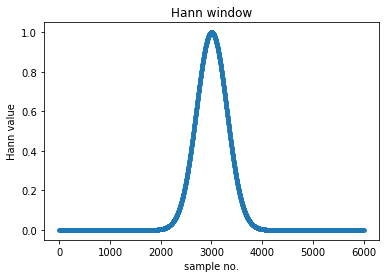

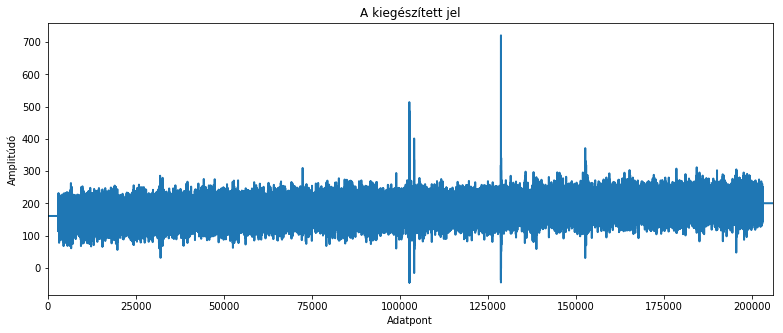

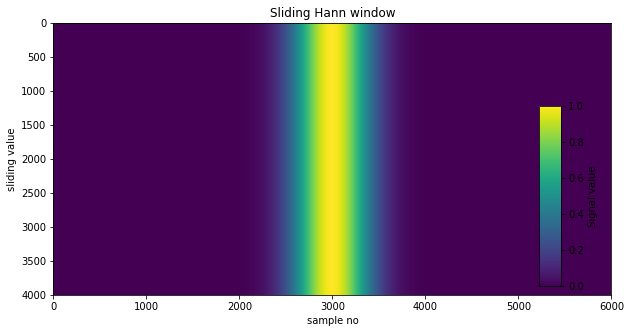

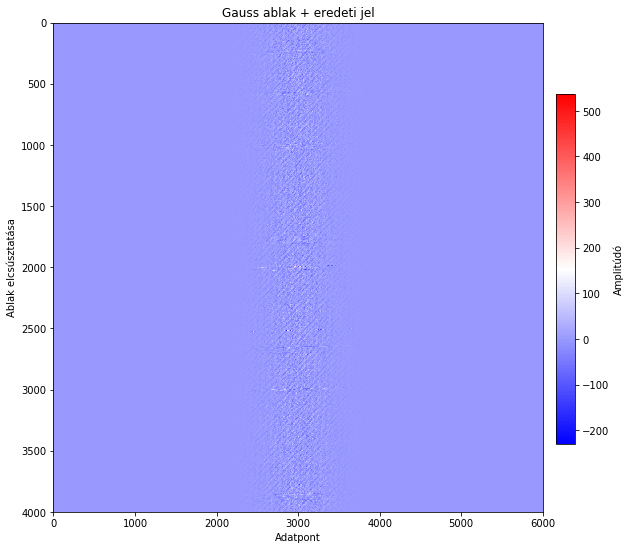

In [18]:
t0=time.time()
win_r = 3000 #1000
d_win=50#random.randint(200,300)
std=300 #150
win_base = scipy.signal.gaussian(2*win_r+1, std=std)#np.wining(2*win_r+1)

plt.plot(win_base,".-")
plt.title('Hann window')
plt.xlabel('sample no.')
plt.ylabel('Hann value')
#plt.show()

z_padded_s = np.zeros (samples+2*win_r)
z_0=z_padded_s
z_padded_s[win_r:-win_r] = s
z_padded_s[0:win_r]=np.average(z_padded_s[win_r+1:2*win_r])
z_padded_s[-win_r:]=np.average(z_padded_s[-2*win_r:-win_r-1])
x_win=np.linspace(0.0, t+(2*win_r/s_rate), samples+2*win_r)

plt.figure(figsize=(13,5))
plt.plot(z_padded_s,"-",linewidth = 2)#x_win,idő (s),max(x_win)
plt.xlim((0,samples+2*win_r))
plt.title('A kiegészített jel')
plt.xlabel('Adatpont')
plt.ylabel('Amplitúdó')
plt.savefig('sxr2_p.pdf')
#plt.show()

win = np.zeros((int(samples/d_win+1), 2*win_r+1))
for i in range(int(samples/d_win+1)):
    win [i]=win_base

plt.figure(figsize=(10,5))
plt.imshow(win,aspect='auto')
plt.title('Sliding Hann window')
plt.xlabel('sample no')
plt.ylabel('sliding value')
#plt.subplots_adjust(right=0.95)
cax = plt.axes([0.8, 0.15, 0.03, 0.5])
plt.colorbar(cax=cax).set_label('Signal value')
#plt.show()

z_win = np.zeros((int(samples/d_win+0.9), win_r*2+1))
for i in range(int(samples/d_win+0.9)):
    if i<1000001:
        z_win[i] = win[i] * (z_padded_s [d_win*i:d_win*i+win_r+win_r+1]-np.average(z_padded_s [d_win*i:d_win*i+win_r+win_r+1]))
    #z_win[i] = win[i] * (z_padded_s [d_win*i:d_win*i+win_r+win_r+1])

plt.figure(figsize=(9,9))
plt.imshow(z_win,aspect='auto',cmap='bwr')#, extent=(min_t*s_rate/d_win,max_t*s_rate/d_win,max_t*s_rate,min_t*s_rate)
plt.title('Gauss ablak + eredeti jel')
plt.xlabel('Adatpont')
plt.ylabel('Ablak elcsúsztatása')
plt.subplots_adjust(right=0.88)
cax = plt.axes([0.90, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig('z_win.pdf')
#plt.show()

z_win_fft = np.zeros((int(samples/d_win+0.9), win_r*2+1))
for i in range(int(samples/d_win+0.9)):
    if i % 1000 == 0:
        print('a')
    if i<1000001:
        z_win_fft[i] = np.abs(scipy.fftpack.fft(z_win[i]))  
t1=time.time()

print(z_win_fft.min()**2)
print(z_win_fft.max()**2)
print(std)

z_win_fft_cutted = (z_win_fft.T)**2

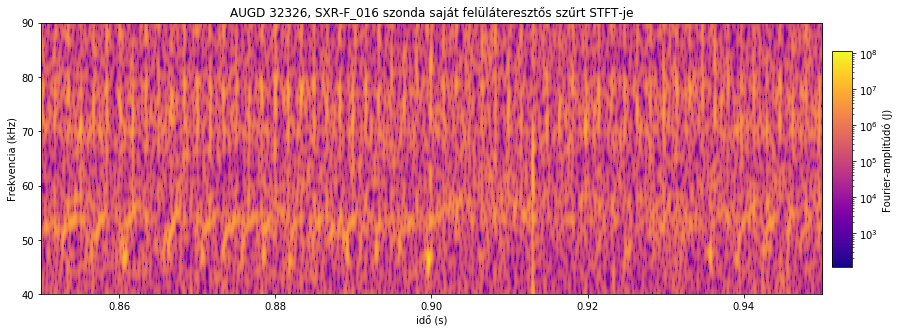

1000005.0000000002 200000


In [19]:
##### %%script false
colornorm=colors.LogNorm(vmin=z_win_fft_cutted.max()/10**6, vmax=z_win_fft_cutted.max())#40000000#10
logax = np.linspace(int(np.log10(z_win_fft_cutted.min())),int(np.log10(z_win_fft_cutted.max())),int(np.log10(z_win_fft_cutted.max()))-int(np.log10(z_win_fft_cutted.min()))+1)
logax = 10**logax
fig, ax = plt.subplots(figsize=(14,5))
#extent=[0,t-(2*win_r/s_rate),0,frangemax/t],
#plt.figure(figsize=(15,10))
#ax.plot(x,np.abs(full_f),color='g',linewidth=3,linestyle='dashed',alpha=0.6)#img = ax.
img = plt.imshow(z_win_fft_cutted,cmap='plasma',  aspect='auto', extent=[min_t,max_t,2*nyquist/1000,0], norm=colornorm)#interpolation='gaussian',*30000000/4
#plt.title('39424-es kisülés, J051-es szonda STFT-je')
plt.title(shot+' szonda saját felüláteresztős szűrt STFT-je')
#plt.title('AUGD 34924, B31-40-es szonda STFT-je')
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')#('time (s)')
plt.ylim(40,90)
plt.xlim(0.85,0.95)
plt.subplots_adjust(right=0.90)
#plt.gca().invert_yaxis()
cbar=plt.colorbar(img,cax=plt.axes([0.91, 0.2, 0.02, 0.6]),ticks=None)
cbar.set_label('Fourier-amplitúdó (J)')
#plt.axis([2.13,2.15,min(s),20000])
cbar.set_ticks(logax)
plt.savefig(shot+' '+str(min_t)+'-'+str(max_t)+' stft.pdf')#34924_40
plt.show()

print(nyquist,frangemax)


 shotname:  AUGD 32326, SXR-F_010


Calculating main variables...
Padding signal...

C:\Users\Marci\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.



Calculating STFT...
STFT 0.0 %
STFT 10.0 %
STFT 20.0 %
STFT 30.0 %
STFT 40.0 %
STFT 50.0 %
STFT 60.0 %
STFT 70.0 %
STFT 80.0 %
STFT 90.0 %
Max and min amplitudes:
8.556446381747478e-08
235693797.6741269

 shotname:  AUGD 32326, SXR-F_011


Calculating main variables...
Padding signal...
Calculating STFT...
STFT 0.0 %
STFT 10.0 %
STFT 20.0 %
STFT 30.0 %
STFT 40.0 %
STFT 50.0 %
STFT 60.0 %
STFT 70.0 %
STFT 80.0 %
STFT 90.0 %
Max and min amplitudes:
2.679189389895207e-08
1850161030.460101

 shotname:  AUGD 32326, SXR-F_012


Calculating main variables...
Padding signal...
Calculating STFT...
STFT 0.0 %
STFT 10.0 %
STFT 20.0 %
STFT 30.0 %
STFT 40.0 %
STFT 50.0 %
STFT 60.0 %
STFT 70.0 %
STFT 80.0 %
STFT 90.0 %
Max and min amplitudes:
0.04833664905263597
5640399155.884066

 shotname:  AUGD 32326, SXR-F_013


Calculating main variables...
Padding signal...
Calculating STFT...
STFT 0.0 %
STFT 10.0 %
STFT 20.0 %
STFT 30.0 %
STFT 40.0 %
STFT 50.0 %
STFT 60.0 %
STFT 70.0 %
STFT 80.0 %
STFT 90.0 

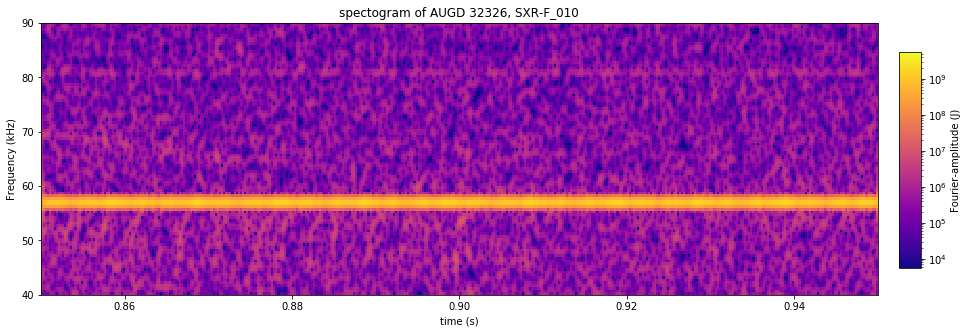

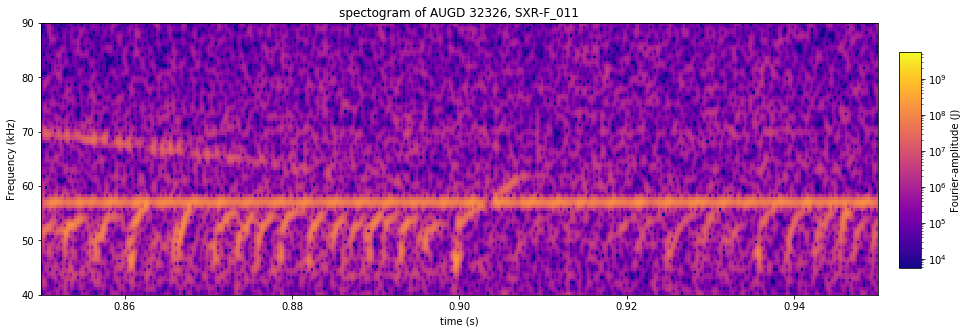

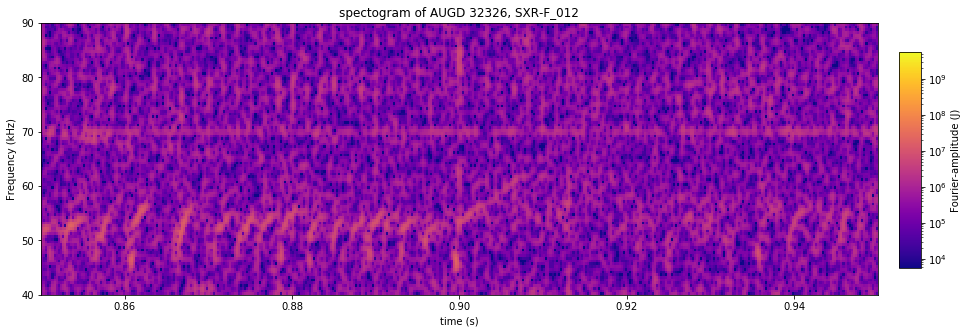

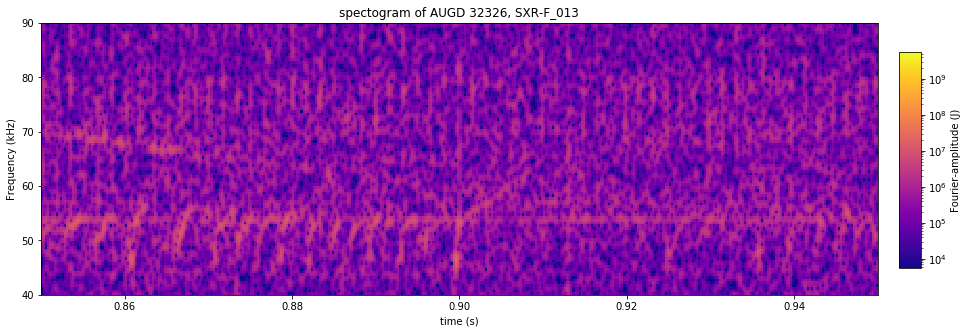

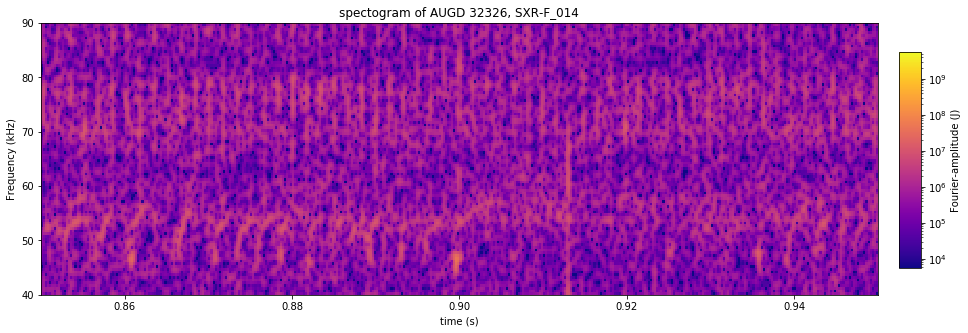

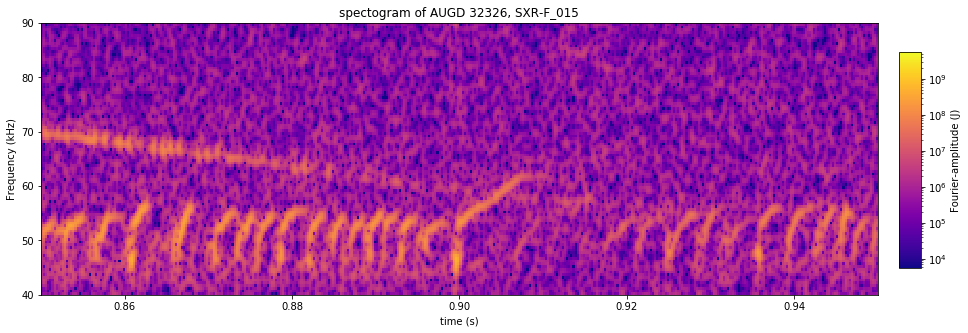

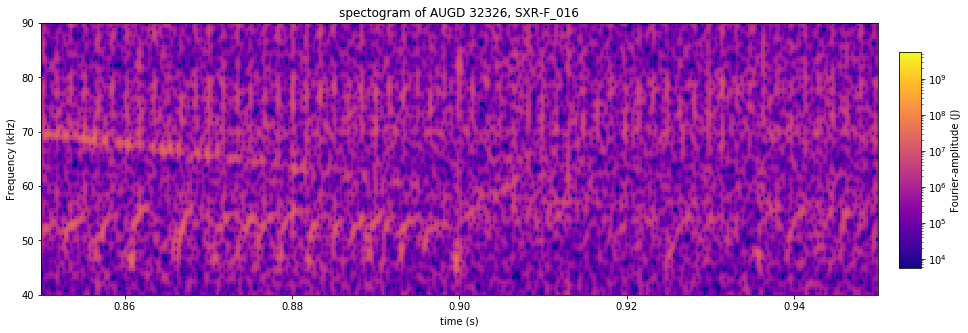

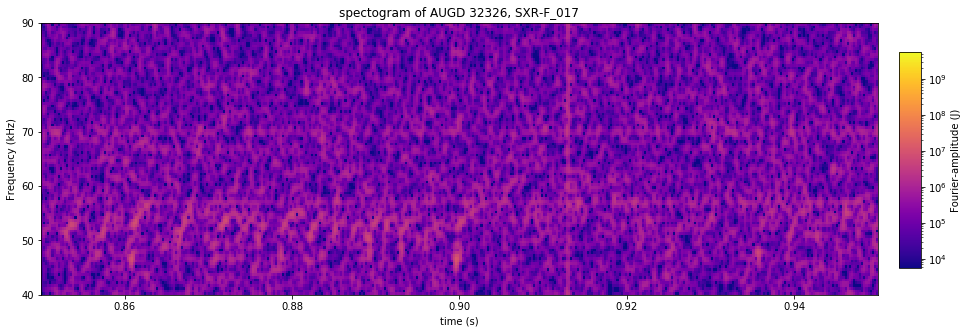

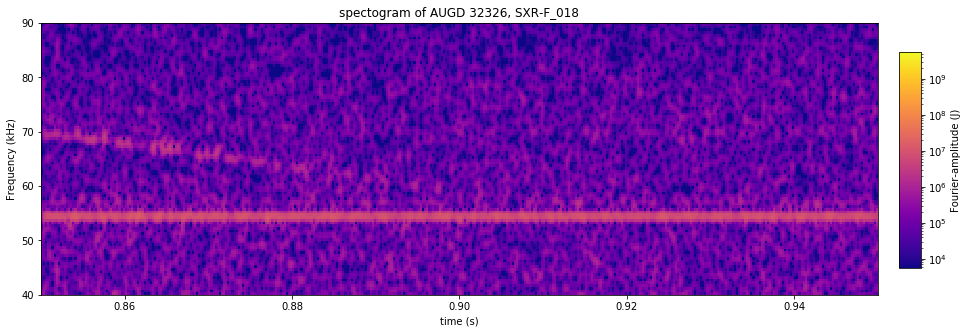

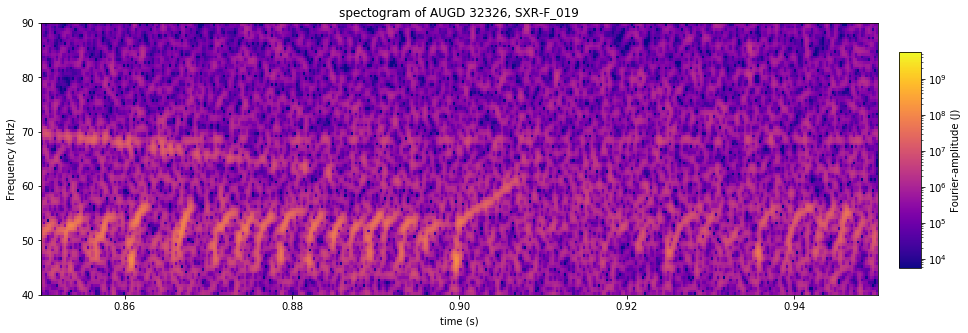

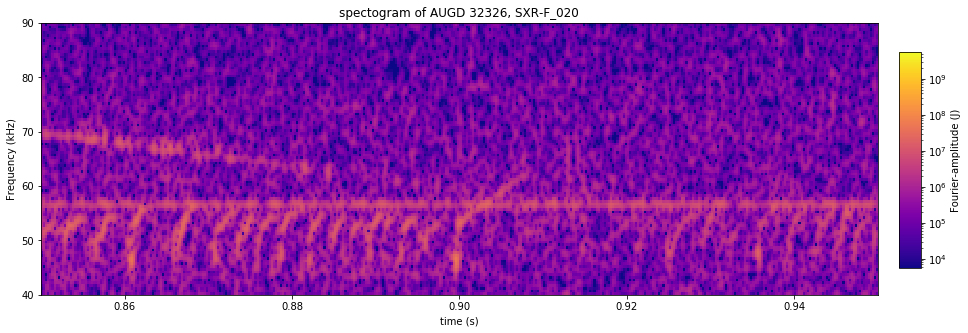

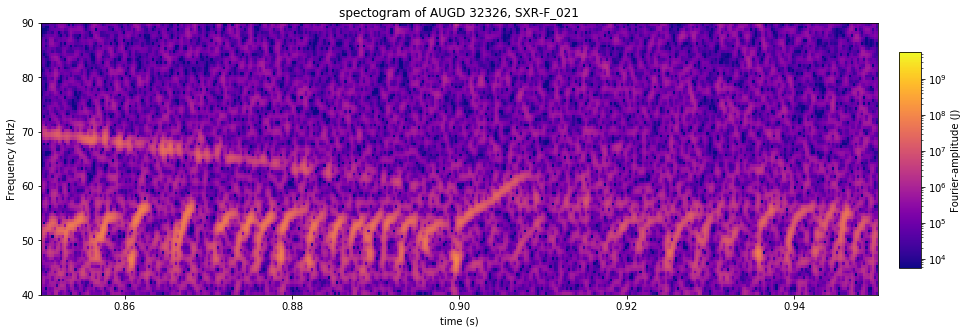

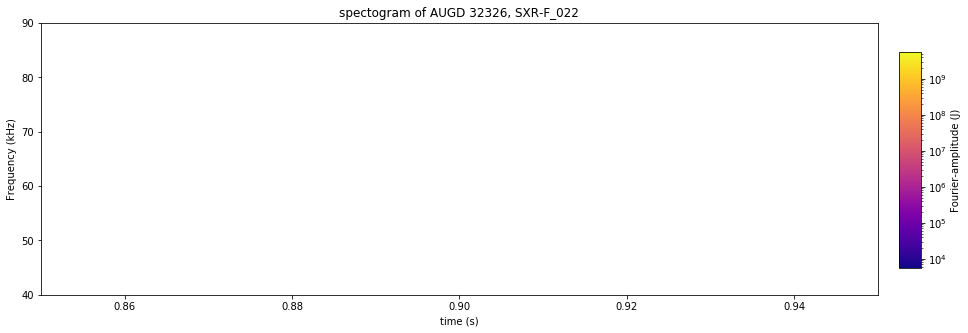

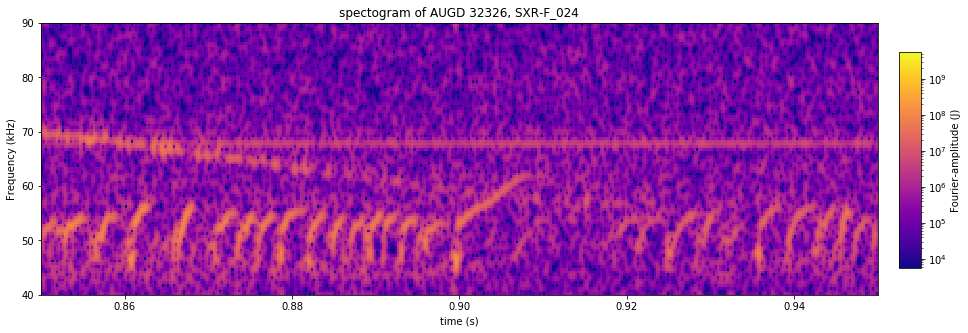

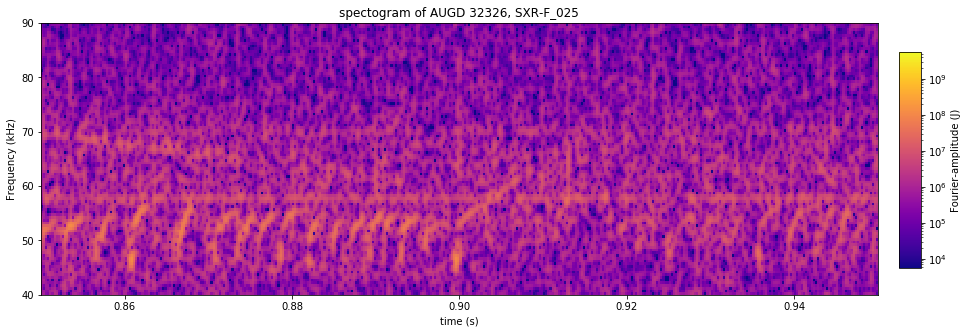

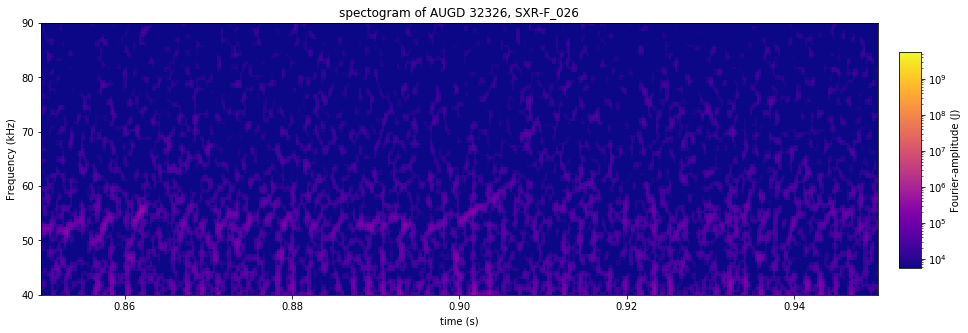

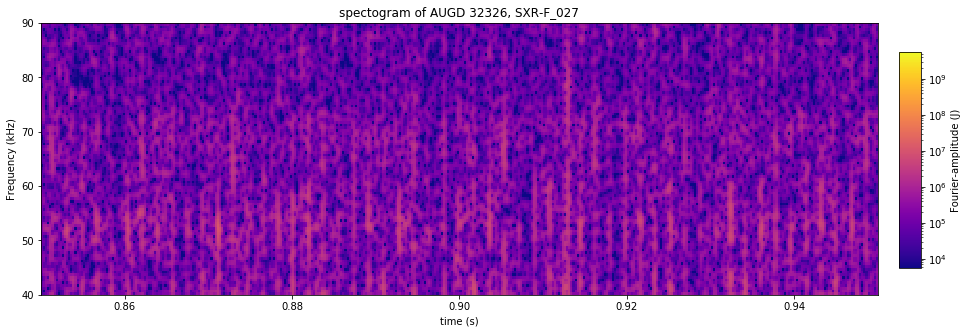

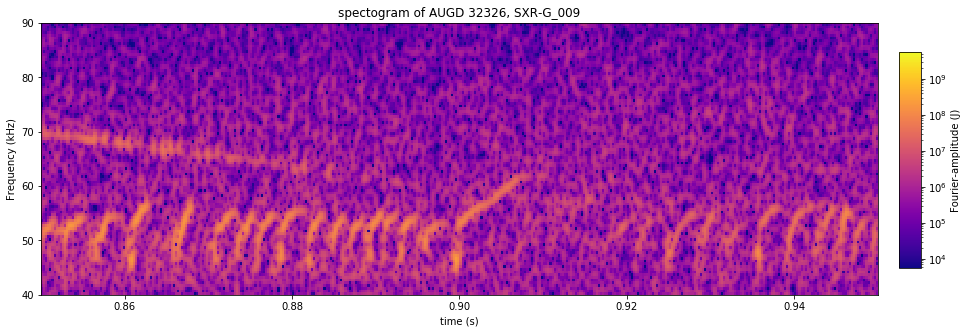

In [30]:
#%%script false
#path ='C:\\Users\\Marci\\Documents\\transientwaves\\imputdata\\in\\'#pc
path ='E:\\marci main\\Fusion\\inputdata\\in\\' #pc_big 
#path ='C:\\Users\\win10\\Downloads\\transient-waves\\inputdata\\in\\'#laptop

loops = 18#np.size(sav1['channels'])#18#
zero_loops = 0

for shot_i in range(loops): 
    win_r = 2000 #1000
    d_win=500#random.randint(200,300)
    std=500 #150
    
    s=np.array(sav1['data'][shot_i+1])#
    if (np.average(abs(s))) < 0.1:
        #shot_i=shot_i+1
        zero_loops = zero_loops+1
        print('zeros shot:',shot_i)
        #s=np.array(sav1['data'][shot_i])
    x=np.array(sav1['timeax'])
    s = s.astype(float)
    x = x.astype(float)
    samples=s.size
    t = max(x) - min(x)
    stft_len = int(samples/d_win+0.9)
    
    sxr_name=str(sav1['channels'][shot_i])[2:4]+'R'+str(sav1['channels'][shot_i])[5:-1]
    if shot_i == 0:
        shot_name=[(str(os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10]+', '+sxr_name))]
        
    else:
        shot_name.append(str(os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10]+', '+sxr_name))
    print("\n","shotname: ",shot_name[shot_i])
    print("\n")

    print('Calculating main variables...')
    min_t=0.85#,min(x)#1.4#
    max_t=0.95#max(x)#2.1#

    
    full_f = np.zeros(samples)
    t=max(x)-min(x)
    nyquist=samples/2/t
    frangemax=nyquist#250000#
    xf=np.linspace(0.0, frangemax, frangemax*t+1)
    s_rate=x.size/t

    t=max_t-min_t
    min_x=int(s_rate*(min_t-min(x)))
    max_x=int(s_rate*(max_t-min(x)))
    samples=max_x-min_x

    x=x[min_x:max_x]
    s=s[min_x:max_x]
    
    print('Padding signal...')
    win_base = scipy.signal.gaussian(2*win_r+1, std=std)

    z_padded_s = np.zeros(samples+2*win_r)
    z_padded_s[win_r:-win_r] = s
    z_padded_s[0:win_r]=np.average(z_padded_s[win_r+1:2*win_r])
    z_padded_s[-win_r:]=np.average(z_padded_s[-2*win_r:-win_r-1])
    x_win=np.linspace(0.0, t+(2*win_r/s_rate), samples+2*win_r)

    win = np.zeros((stft_len, 2*win_r+1))
    for i in range(stft_len):
        win [i]=win_base

    z_win = np.zeros((int(samples/d_win+0.9), win_r*2+1))
    for i in range(stft_len):
        if i<1000001:
            z_win[i] = win[i] * (z_padded_s [d_win*i:d_win*i+win_r+win_r+1]-np.average(z_padded_s [d_win*i:d_win*i+win_r+win_r+1]))
        #z_win[i] = win[i] * (z_padded_s [d_win*i:d_win*i+win_r+win_r+1])

    print('Calculating STFT...')
    z_win_fft = np.zeros((int(samples/d_win+0.9), win_r*2+1))
    for i in range(int(samples/d_win+0.9)):
        if i % int(stft_len/10) == 0:
            print('STFT',i/int(stft_len/10)*10,'%')
        if i<1000001:
            z_win_fft[i] = np.abs(scipy.fftpack.fft(z_win[i]))  
    t1=time.time()

    print('Max and min amplitudes:')
    print(z_win_fft.min()**2)
    print(z_win_fft.max()**2)

    if shot_i==0:
        z_win_fft_cutted=np.zeros((loops,int(frangemax*(2*win_r+1)/s_rate),stft_len))
        stft_max=z_win_fft_cutted.max()
        stft_min = z_win_fft_cutted.min()
    
    #print(z_win_fft_cutted.shape)
    #print(np.transpose(np.square(z_win_fft))[:int(frangemax*(2*win_r+1)/s_rate)].shape)
    #print(int(frangemax*(2*win_r+1)/s_rate))
    
    if stft_max<z_win_fft_cutted.max():
        stft_max = z_win_fft_cutted.max()
    if stft_min==0:
        stft_min = stft_max/1000
    if stft_min>z_win_fft_cutted.min() and z_win_fft_cutted.min()>0:
        stft_min = z_win_fft_cutted.min()
    
    z_win_fft_cutted[shot_i-1] = np.transpose(np.square(z_win_fft))[:int(frangemax*(2*win_r+1)/s_rate)]
    
print('Plotting...')
print(z_win_fft_cutted.shape)
print(stft_max)

 #all subplots have the same height
    
for i in range(loops):
    colornorm=colors.LogNorm(vmin=stft_max/10**6, vmax=stft_max)
    logax = np.linspace(int(np.log10(stft_min)),int(np.log10(stft_max)),int(np.log10(stft_max))-int(np.log10(stft_min))+1)
    logax = 10**logax
    fig, ax = plt.subplots(figsize=(15,5))  #*loops
    #plt.subplot(loops,1,i+1)
    img = plt.imshow(z_win_fft_cutted[i],cmap='plasma',  aspect='auto', extent=[min_t,max_t,frangemax/1000,0], norm=colornorm)
    #if i == 0:
    plt.title('spectogram of '+shot_name[i])
    plt.ylabel('Frequency (kHz)')
    plt.xlabel('time (s)')
    plt.ylim(40,90)
    #plt.xlim(0.85,0.95)
    plt.subplots_adjust(right=0.90)
    #plt.gca().invert_yaxis()
    cbar=plt.colorbar(img,cax=plt.axes([0.92, 0.2, 0.02, 0.6]),ticks=None)#/np.sqrt(loops)
    cbar.set_label('Fourier-amplitude (J)')
    #cbar.set_ticks(logax)

    #shots_name=str(os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10])
    plt.savefig(shot_name[i]+', '+ "%.2f" % min_t +'-'+"%.2f" % (max_t)+' stft.pdf')#34924_40
    plt.show()

In [ ]:
print('Plotting...')
print(z_win_fft_cutted.shape)
print(stft_max)

colornorm=colors.LogNorm(vmin=stft_max/10**6, vmax=stft_max)
logax = np.linspace(int(np.log10(stft_min)),int(np.log10(stft_max)),int(np.log10(stft_max))-int(np.log10(stft_min))+1)
logax = 10**logax
fig, ax = plt.subplots(figsize=(15,5*loops)) #all subplots have the same height
    
for i in range(loops):
    plt.subplot(loops,1,i+1)
    img = plt.imshow(z_win_fft_cutted[i],cmap='plasma',  aspect='auto', extent=[min_t,max_t,frangemax/1000,0], norm=colornorm)
    #if i == 0:
    plt.title('spectogram of '+shot_name[i])
    plt.ylabel('Frequency (kHz)')
    plt.xlabel('time (s)')
    plt.ylim(40,90)
    #plt.xlim(0.85,0.95)
    plt.subplots_adjust(right=0.90)
    #plt.gca().invert_yaxis()
    cbar=plt.colorbar(img,cax=plt.axes([0.92, 0.6/np.sqrt(loops), 0.02, 0.6/np.sqrt(loops)]),ticks=None)
    cbar.set_label('Fourier-amplitude (J)')
    #cbar.set_ticks(logax)

shots_name=str(os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10])
plt.savefig(shots_name+', '+ "%.2f" % min_t +'-'+"%.2f" % (max_t)+' stft.pdf')#34924_40
plt.show()

In [ ]:
print(shot_name)

In [ ]:
#%%script false
#ridge_no = 1
print(samples/d_win)

print(s_rate-0.9)
print(nyquist/((2*win_r+1)/s_rate-0.9))
ridge_d=40#00#50# #windth of search if rige is lost
ridge_d2=10#00   #width of search if rige is followed
ridge_start=30#40000#2#
ridge = np.zeros(int(samples/d_win+0.9))
ridge_h = np.zeros(int(samples/d_win+0.9))
maxi=z_win_fft.max()/40 # minimum treshold
print(maxi)

for i in range(int(samples/d_win+0.9)):
    ridgeval=0  #max(z_spy_stft[i][:])
    if (i==0) or (ridge[i-1]==0):
        for j in range(int(ridge_d*(2*win_r+1)/(s_rate-0.9))):
            j2=j+int((ridge_start)*(2*win_r+1)/(s_rate-0.9))
            if ridgeval < z_win_fft[i][j2]:
                ridgeval=z_win_fft[i][j2]
                ridge[i]= j2
    else:
        for j in range(int(ridge_d2*(2*win_r+1)/(s_rate-0.9))):
            j2=int(j+ridge[i-1]-(ridge_d2/2)*(2*win_r+1)/(s_rate-0.9))
            if ridgeval < z_win_fft[i][j2]:
                ridgeval=z_win_fft[i][j2]
                ridge[i]= j2
                #print(j2, z_spy_stft[j2][i])
    if ridgeval<(maxi):
        ridgeval =0
        ridge [i]=0
    ridge_h[i]=ridgeval**(1/2)
    #print(i, ridge [i])
    #print (i,"  ",ridge[i],"\t", ridgeval,"\t", z_spy_stft[i][int(ridge[i])])

ridge=ridge*(s_rate/(2*win_r+1))

#proc_x=np.linspace(min_t,max_t,np.size(ridge))
ridge[ ridge==0 ] = np.nan
plt.figure(figsize=(14,3.5))
plt.title(shot+' szonda maximum frekvenciaértékei')
plt.plot(np.linspace(min_t,max_t,np.size(ridge)),ridge,'.-',x,full_f)
plt.grid(True)
plt.legend(('Kiszámolt', 'Eredeti'))
#yaxismax=1/2**(view.value/12)
plt.xlim(min_t,max_t)
#plt.ylim(ridge_start/1100,)
#plt.ylim(0,200)
#plt.xlim(0.89,0.91)
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')
plt.savefig(shot+' f_max.pdf')
plt.show()
#print(z_spy_stft.shape)
print(ridge.shape)

In [ ]:
#%%script false
plt.figure(figsize=(14,3.5))
x_ridge=np.linspace(min_t,max_t,np.size(ridge))
diff_ridge=full_f[0::d_win]-ridge#15+10*np.sin(np.pi*x_ridge)
plt.plot(x_ridge,abs(diff_ridge))#/ridge
plt.ylabel('Frekvencia (Hz)')
plt.xlabel('idő (s)')
plt.grid(True)
plt.xlim(min_t,max_t)
#plt.ylim(0,4)
#plt.savefig('t_diff.pdf')
plt.show()
#((1/(np.size(ridge)-1))*sum((diff_ridge/ridge)**2))**(1/2)
np.average(abs(diff_ridge))

In [ ]:
fig, ax = plt.subplots(figsize=(14,5))
#ax.plot(x,np.abs(full_f),color='g',linewidth=3,linestyle='dashed',alpha=0.6)#img = ax.
ax.plot(np.linspace(min_t,max_t,np.size(ridge)),ridge,'.',color='g',alpha=0.6)
img = plt.imshow(z_win_fft_cutted,cmap='plasma',  aspect='auto', extent=[min_t,max_t,2*nyquist,0], norm=colornorm)#interpolation='gaussian',*30000000/4
#plt.title('39424-es kisülés, J051-es szonda STFT-je')
plt.title(shot+' szonda saját felüláteresztős szűrt STFT-je')
#plt.title('AUGD 34924, B31-40-es szonda STFT-je')
plt.ylabel('Frekvencia (Hz)')
plt.xlabel('idő (s)')#('time (s)')
plt.ylim(0,frangemax)
#plt.xlim(1.9,2.4)
plt.subplots_adjust(right=0.90)
#plt.gca().invert_yaxis()
cbar=plt.colorbar(img,cax=plt.axes([0.91, 0.2, 0.02, 0.6]),ticks=None)
cbar.set_label('Fourier-amplitúdó (J)')
#plt.axis([2.13,2.15,min(s),20000])
cbar.set_ticks(logax)
plt.savefig(shot+' '+str(min_t)+'-'+str(max_t)+' stft.pdf')#34924_40
plt.show()

In [ ]:
ridge_h[ ridge_h==0 ] = np.nan
print(maxi**(1/2))
plt.figure(figsize=(10,3.5))
plt.title('Az amplitúdó a maximum frekvenciaértékeknél, '+shot)#, AUGD 34924 J051-es szonda
plt.plot(np.linspace(min_t,max_t,np.size(ridge_h)),ridge_h**2,x,380*amp,'-',markersize=1)#,x,3*abs(np.sin(2*np.pi*x))+2,
plt.grid(True)
plt.xlim(min_t,max_t)
#plt.xlim(0.89,0.91)
#plt.ylim(maxi**(1/2)/2,max(ridge_h)*1.05)
plt.ylabel('Amplitúdó')
plt.xlabel('idő (s)')
#plt.yscale("log")
plt.savefig(shot+'_amp.pdf')
plt.show()
print(ridge.shape)

amp_diff=np.zeros(int(samples/d_win+0.9))#
for i in range(int(samples/d_win+0.9)):
    amp_diff[i]=np.sqrt(ridge_h[i])-3*abs(np.sin(2*np.pi*x[20*i]))

## Tasks
<br> 
<br> Import and evaluate chirps
<br> Reconstruct wave frequencies and amplitudes
<br> Get the radial ?function of several wave types